## Assignment 5: Linear Regression

#### Introduction

Using ternary system to predict glass formability of the complete quaternary system (Co-Zr-Cr-Ti)

### Note:
* most codes are generated by Co-pilot or borrowed from PRA 5, except for the codes followed by triple-pound (###) comments

_QUESTIONS: what does leaving out one element (which can still be computed by 100% minus all elements) do for the linear regression? what if I included all compositions when doing the training?_

_QUESTIONS: why do we transform X_test by StandardScaler that was fit on X_train? Why can't we transform the whole thing before split into train and test?_

_PROBLEM with Co-pilot: the comments to guide copilot are not the best comments to guide myself. The best comments for myself are those signifying **why** I do this, but not "what I am doing"._

_TRIED multicomponent polynomial fitting, but can't get the arrangement of X right... The tutorials online all required to add more columns which are the original column's ^1, ^2 and ^3. Seems to be a very rebose process to do CV with POLYnom fitting. Wish Sklearn had a more intuitive polynomial fit process_

_HOW can I visualize how good the model is? it is in multi-dim space_

_LEARNED that if something does not work as expected, instead of believing my code is wrong, think: is this reasonable?_

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 0. Import data, merge all three tabs into one DataFrame

* _need to clean data and perform correlation analysis?_

In [8]:
### Importing the dataset, dropna, multiply by 100
sheets = ['CrTiZr', 'CrCoZr', 'CoTiZr']
missing = ['Co', 'Ti', 'Cr']

# create an empty dataframe with column names ['Co', 'Ti', 'Cr', 'Zr', 'MaxFWHM']
df = pd.DataFrame(columns = ['Co', 'Ti', 'Cr', 'Zr', 'MaxFWHM'])
### my own forloop
for i in range(len(sheets)):
    sheet_df = pd.read_excel('Metallic Glass Data.xlsx', sheet_name = sheets[i]).dropna()
    sheet_df[missing[i]] = 0
    df = pd.concat([df, sheet_df], ignore_index = True)

### Approach 1: use only the composition as features

* define features X (element compo), and target value y (FWHM)

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate

* Optional: Define a handy function for parity plot

In [4]:
# a little tool to plot parity
from sigfig import round
def parity_plot(y_test, y_hat, title = None, subplot=False):
    '''Improvements: 
    1. make R= value appear as a label, check how PRA did it;
    2. enable subplot, still looks like a hassel'''

    if not subplot: # if subplot is False, 
        plt.figure(figsize=(3, 3)) #create a stand-alone figure

    plt.scatter(y_test, y_hat, c='b', s=4, alpha = 0.4)
    plt.xlabel('max FWHM')
    plt.ylabel('predicted max FWHM')

    r1 = np.arange(0,1,0.1)[:,None]
    r2 = r1
    r2value = round(r2_score(y_test, y_hat),3)
    plt.plot(r1, r2, c='r', label='$R^{2}$='+ str(r2value))
    # make the legend in the proper place
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.title(title)

* make a funtion which makes y predictions based on available X-y dataset

In [5]:
from sklearn.preprocessing import StandardScaler
def poly_predict(X, y, X_test, n_degree = 3, y_train_hat = True):
    '''this function takes the raw training set of X and y, and produce a prediction
    steps involved:
    1. process X and X_test following the same procedure (polynomialize, standardize).
    2. fit the processed X set and y, and use that fit to predict y from X_test
    
    it can be used by itself or inside the loop in the CV functions below'''

    poly = PolynomialFeatures(degree=n_degree, include_bias=False)
    std = StandardScaler()
    RG = LinearRegression(fit_intercept=True)
    
    X_poly, X_test_poly = poly.fit_transform(X), poly.fit_transform(X_test)

    ### Set the std to fit the training set
    std.fit(X_poly)

    ### and apply the std to fit to training AND test X. 
    ### Finalized train and test sets are called X_train and X_test
    X_train, X_test = std.transform(X_poly), std.transform(X_test_poly)

    ### fit linear regression to training set
    RG.fit(X_train, y) 
    
    ### predict the test set
    y_hat = RG.predict(X_test)
    
    ### we can also return the prediction on the training set, if requested
    if y_train_hat:
        y_train_hat = RG.predict(X_train)
        return y_hat, y_train_hat
    else:
        return y_hat


#### 1.1 Perform LOCO-cv: splitting train-test sets by ternary systems

In [9]:
### define a new function, which loops through the ternary systems and output CV scores
def LOCO_cv(df, n_degree = 3, element_order = ['Co', 'Ti', 'Cr']):

    '''this function does mainly two things: 
    Task 1. slice the df into train-test sets by ternary systems, therefore establish the folds for LOCO-CV
    Task 2. borrows the poly_predict function to report training and validation performance needed for parity plot
    '''
    # Perform LOCO-cv on each ternary system
    for e in element_order:
        i = element_order.index(e)+1
        ### use i to index the position of the subplot
        
        df_tr = df[df[e] != 0]   # set those with a certain element as train set,
        df_te = df[df[e] == 0]    # and those without as test
        # Note: can do the other way, but this ensures size(train)>size(test)

        ### define which columns are X and which are y, for both train and test set
        y_train = df_tr.iloc[:, -1].values
        y_test = df_te.iloc[:, -1].values

        X_tr = df_tr.iloc[:, :-1].values
        X_te = df_te.iloc[:, :-1].values

        '''end of Task 1'''

        ### use the handy function to get the y_hat and y_train_hat (for this split)
        y_hat, y_train_hat = poly_predict(X_tr, y_train, X_te, n_degree)
        
        ### make six subplots, first row training error, second row validation error
        plt.figure(6, figsize=(17,11))

        ### make training R2 plots
        plt.subplot(2,3,i)
        parity_plot(y_train, y_train_hat, title = 'train err, split by '+e, subplot = True)

        ### make validation R2 plots
        plt.subplot(2,3, i+3)
        parity_plot(y_test, y_hat, title = 'val err, split by '+e, subplot = True)

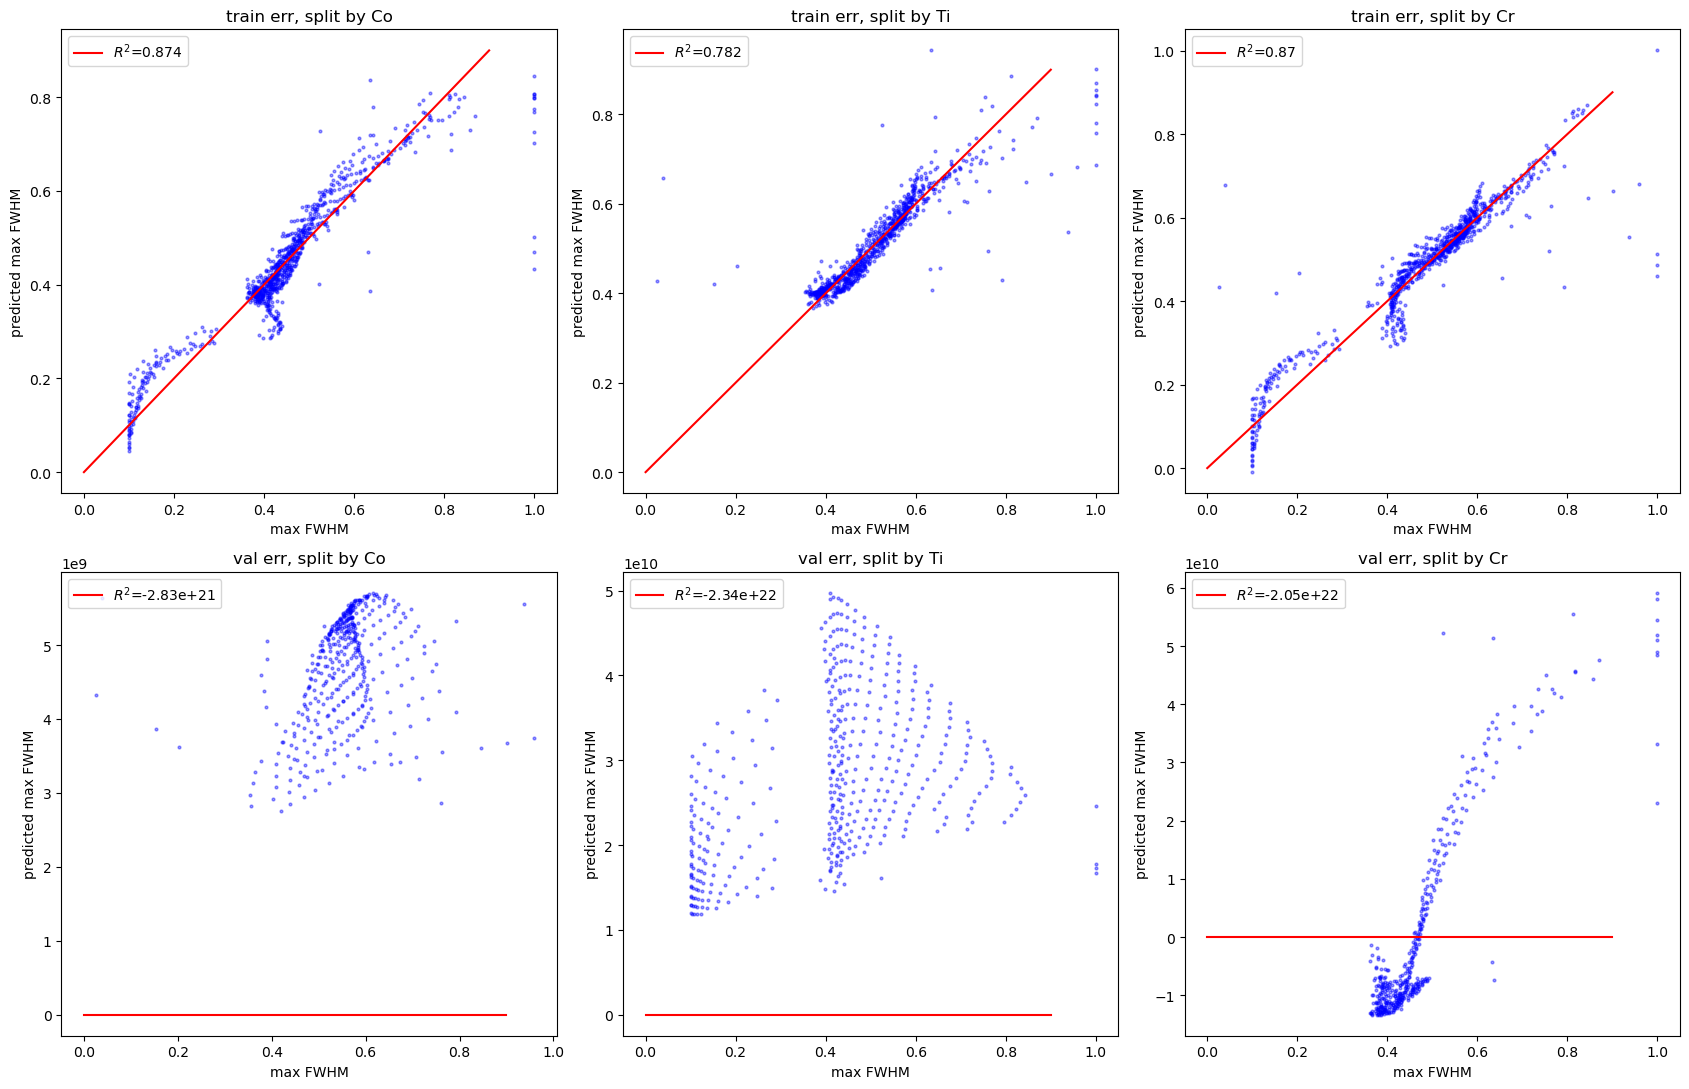

In [10]:
LOCO_cv(df, element_order = ['Co', 'Ti', 'Cr'])

#### 1.2 perform random 5-fold cv
* Use shuffle split, as it is necessary to get a bit of data from each ternary system

In [11]:
# define another function similar to LOCO_cv, but uses random shuffle to split train-test
def random_cv(df, n_degree = 3, n_split = 5):

    # first, grab the X, y from df
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    ### Define a condition which loops through N_split times
    for i in range(1, n_split+1):

        # then using train_test_split, split into test and val set
        X_tr, X_te, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

        '''The code below is identical to the LOCO_cv function'''
        y_hat, y_train_hat = poly_predict(X_tr, y_train, X_te, n_degree)

        ### make 10 subplots, first row training error, second row validation error
        plt.figure(2*n_split, figsize=(20,9))

        plt.subplot(2,n_split,i)
        parity_plot(y_train, y_train_hat, title = 'Train Err, Split #'+ str(i), subplot = True)

        ### make validation R2 plots
        plt.subplot(2,n_split, i+5)
        parity_plot(y_test, y_hat, title = 'Val Err, Split #'+ str(i), subplot = True)
    

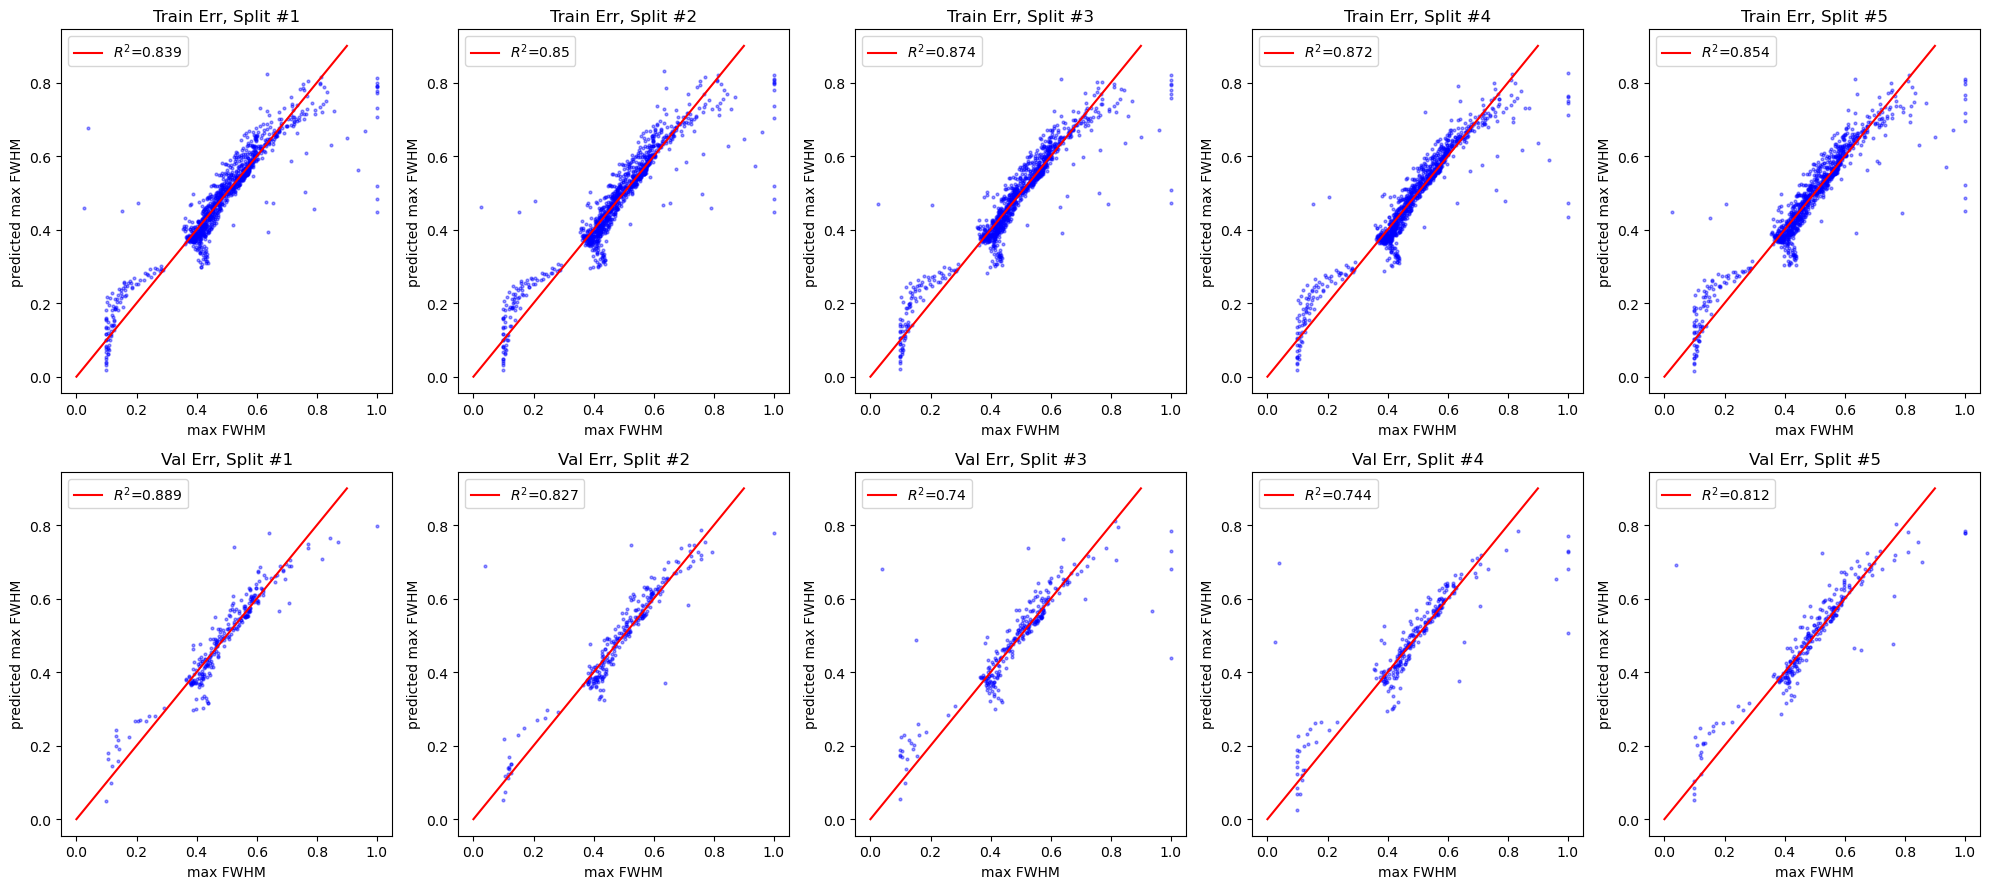

In [12]:
random_cv(df, n_degree=3, n_split = 5)

### Step 2, use featurizers to add more descriptive features

* AtomicPackingEfficiency is chosen because it is said to produce "Packing efficiency based on a geometric theory of the amorphous packing"

In [13]:
### Featurize the dataframe, call it dff
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import YangSolidSolution, Miedema, AtomicPackingEfficiency

In [91]:
# make a featurized dataframe using matminer features

# make a copy of df called dff
dff = df.copy()
# create a column, which is a string of all other columns but the last one
dff.insert(0, 'formula', 
           'Co' + dff['Co'].astype(str) + 'Ti' + dff['Ti'].astype(str) + 
           'Cr' + dff['Cr'].astype(str) + 'Zr' + dff['Zr'].astype(str))

# use the StrToComposition to convert the composition column to a composition object
dff = StrToComposition().featurize_dataframe(dff, 'formula')
# then use the composition object to calculate the other features
dff = AtomicPackingEfficiency().featurize_dataframe(dff, col_id='composition')
dff = Miedema().featurize_dataframe(dff, col_id='composition')
dff = YangSolidSolution().featurize_dataframe(dff, col_id='composition')

# write featurized dff temporarily to a local excel
dff.to_excel('dff.xlsx')

StrToComposition:   0%|          | 0/1323 [00:00<?, ?it/s]

AtomicPackingEfficiency:   0%|          | 0/1323 [00:00<?, ?it/s]

Miedema:   0%|          | 0/1323 [00:00<?, ?it/s]

YangSolidSolution:   0%|          | 0/1323 [00:00<?, ?it/s]

In [337]:
### basic housekeeping: read the featurized file, 
dff = pd.read_excel('dff.xlsx', index_col=0)
### make an additional feature as used in Yang's paper
dff['omega/delta'] = dff['Yang omega'] / dff['Yang delta']
dff = dff.dropna()

# preserve only numerical features
dff = dff.drop(columns=['formula', 'composition'])
# grab the MaxFWHM column and put it as the last column, method from:
# https://stackoverflow.com/questions/35321812/move-column-in-pandas-dataframe
dff = dff[[col for col in dff if col not in ['MaxFWHM']] + ['MaxFWHM']]

In [338]:
import seaborn as sb

def supervised_drop(df, corr_threshold=0.85, must = [], exception = [], color_scheme = 'YlOrBr', heatmap_annote=True, update_df = False):
    '''the function takes a dataframe that is solely numerical. 
    It plots the heatmap of the correlation matrix before and after dropping highly correlated features.'''

    # do a correlation analysis on df, drop the most correlated features
    corr = df.corr().abs()

    # drop the diagonal and upper triangle
    corr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    # find the columns with correlation > threshold, return a list of columns
    to_drop = [column for column in corr.columns if any(corr[column] > corr_threshold)]

    # if must is specified, we must drop them
    for m in must:
        if m not in to_drop and m in df.columns:
            to_drop.append(m)

    # if exceptions are specified, we do not drop them
    for e in exception:
        if e in to_drop:
            to_drop.remove(e)

    # create a new df with correlated features dropped
    df_dropped = df.drop(columns=to_drop)
    
    # same as above, but for the new df
    corr_new = df_dropped.corr().abs()
    # drop the diagonal and upper triangle
    corr_new = corr_new.where(np.triu(np.ones(corr_new.shape), k=1).astype(bool))

    # plot the heatmaps
    # set a fig with two subplots, arranged side by side
    fig, (ax1, ax2) = plt.subplots(nrows=2)
    fig.subplots_adjust(wspace=0.01)

    # plot the heatmaps. 
    ### .T is just to put the remaining matrix on the bottom, for better readability
    sb.heatmap(corr.T, cmap=color_scheme, ax = ax1, annot=heatmap_annote)
    sb.heatmap(corr_new.T, cmap=color_scheme, ax=ax2, annot=heatmap_annote)
    sb.set(rc={'figure.figsize':(20,16)})
    plt.tight_layout()
    plt.show()

    ### if choose to update, drop correlated features directly in the original df 
    if update_df == True:
        df = df_dropped 
    
    return df, to_drop

#### use the new function to tune the drop threshold and criteria. 

* Miedma features are highly inter-correlated, therefore dropped

* since we want to keep Young's features for plotting, we must prioritize dropping other features. Therefore when **_Miedema_deltaH_inter_** is correlated to **_Young_delta_**, and the former one is dropped 

* we must also keep the **_MaxFWHM_** column

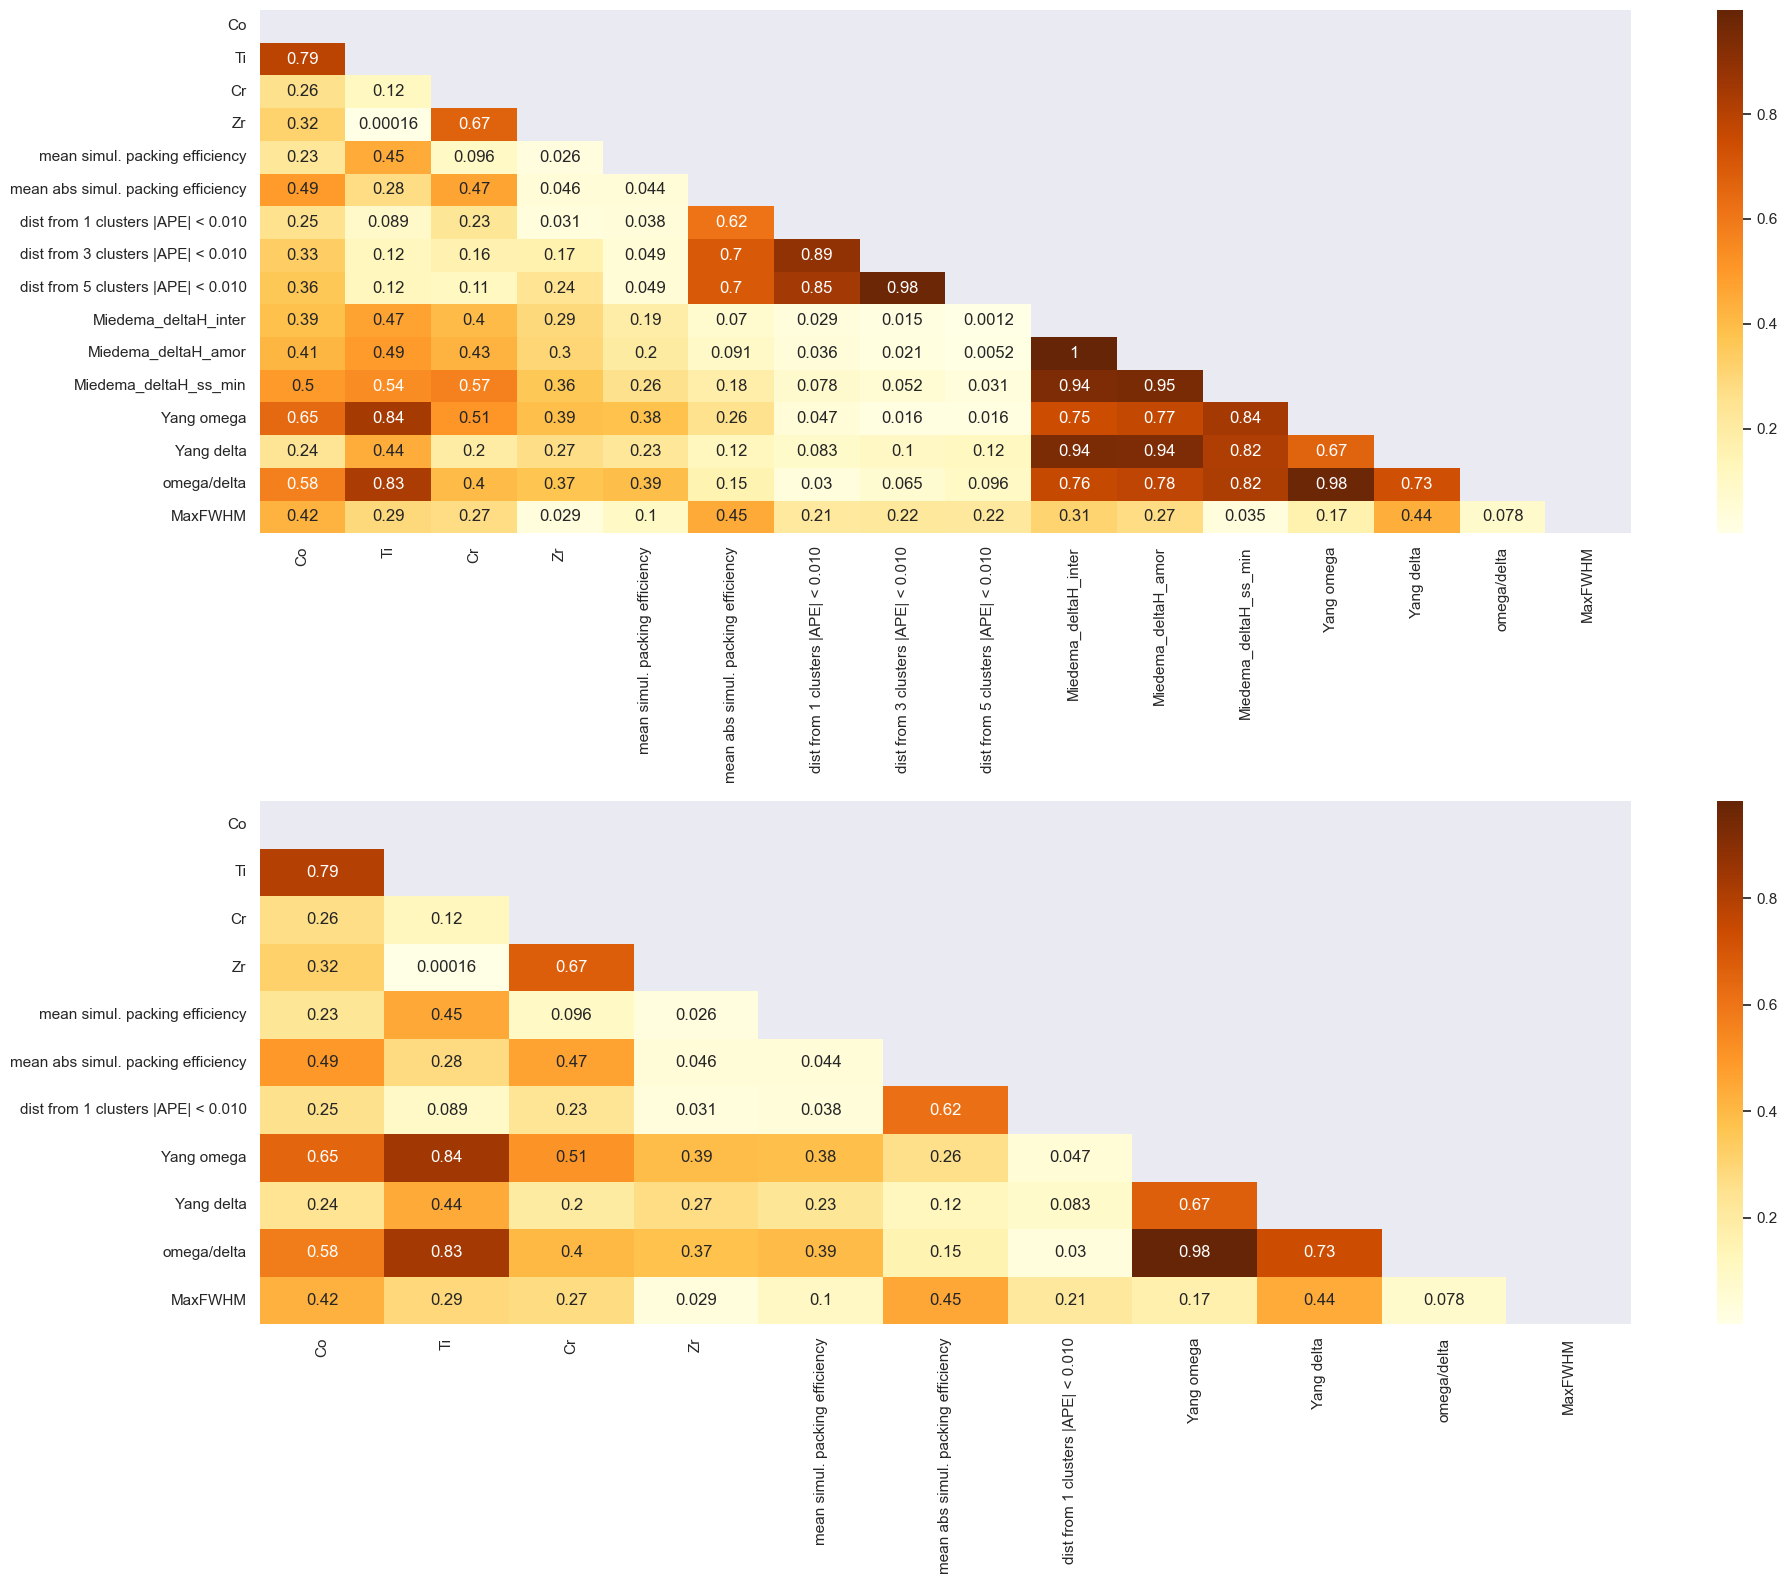

In [339]:
dff, dff_to_drop = supervised_drop(dff, must = ['Miedema_deltaH_inter'], 
                exception = ['Yang omega', 'Yang delta', 'omega/delta', 'MaxFWHM'], update_df=True)

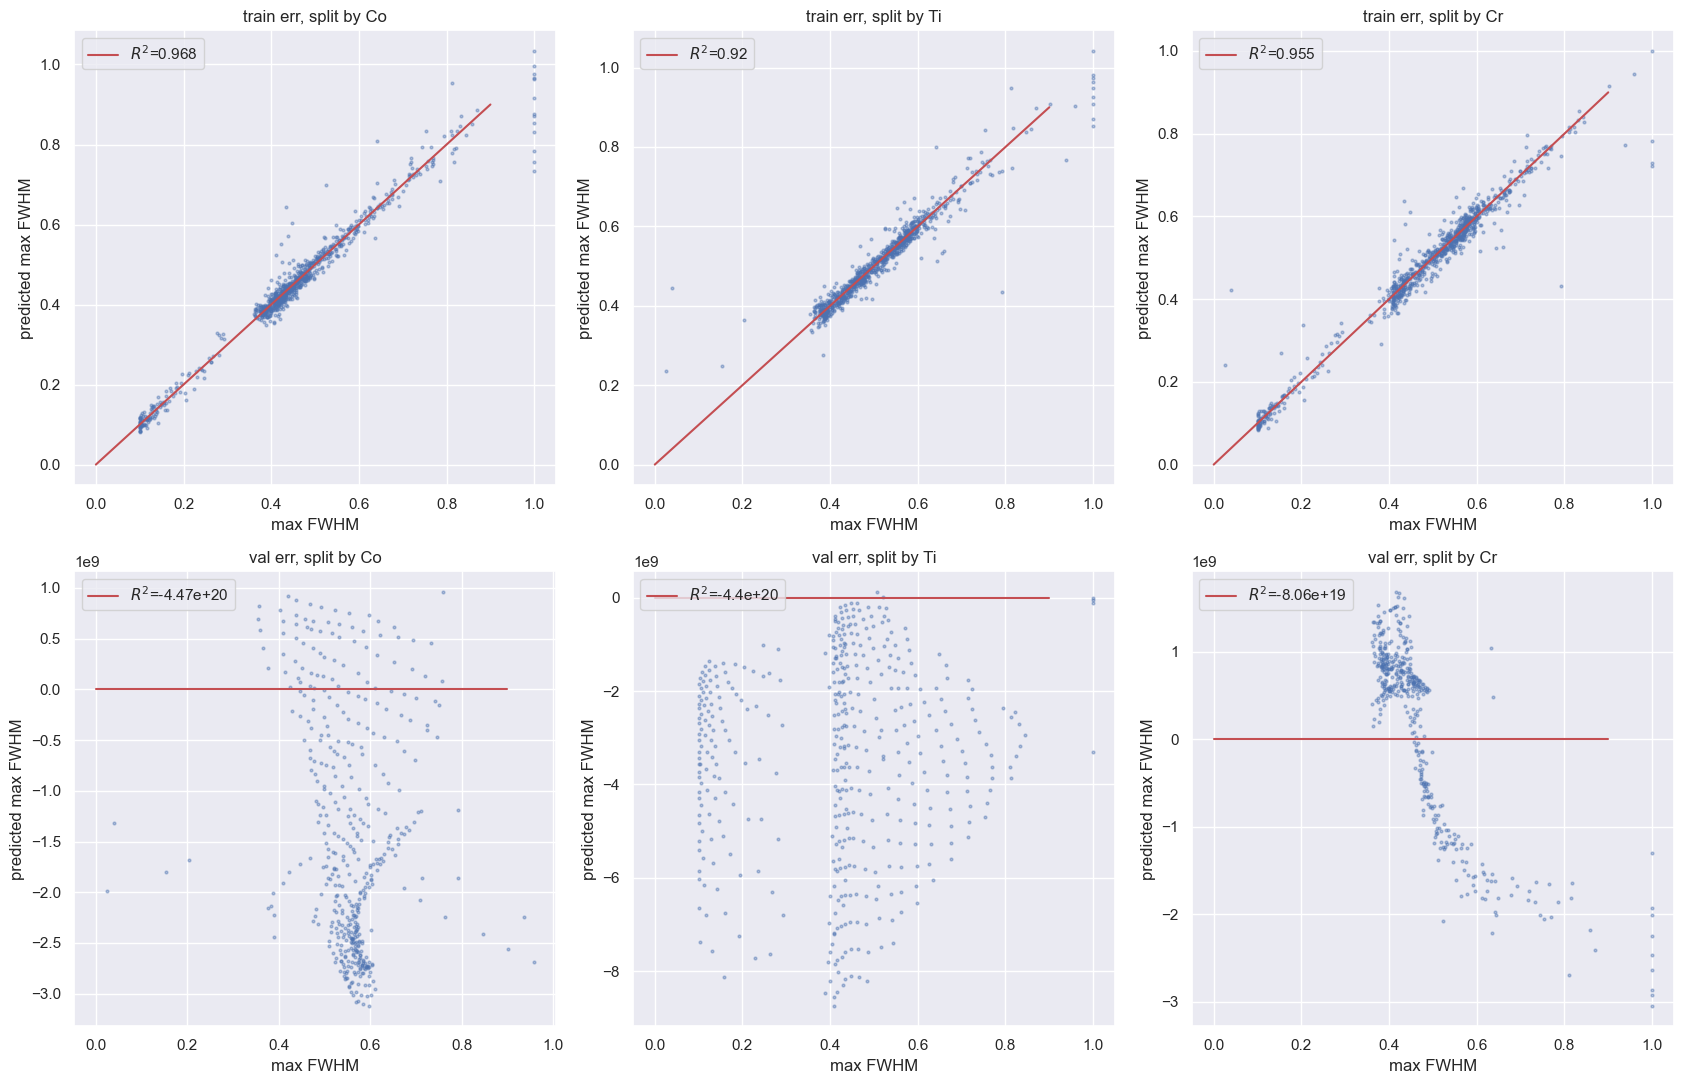

In [340]:
LOCO_cv(dff, n_degree=3)

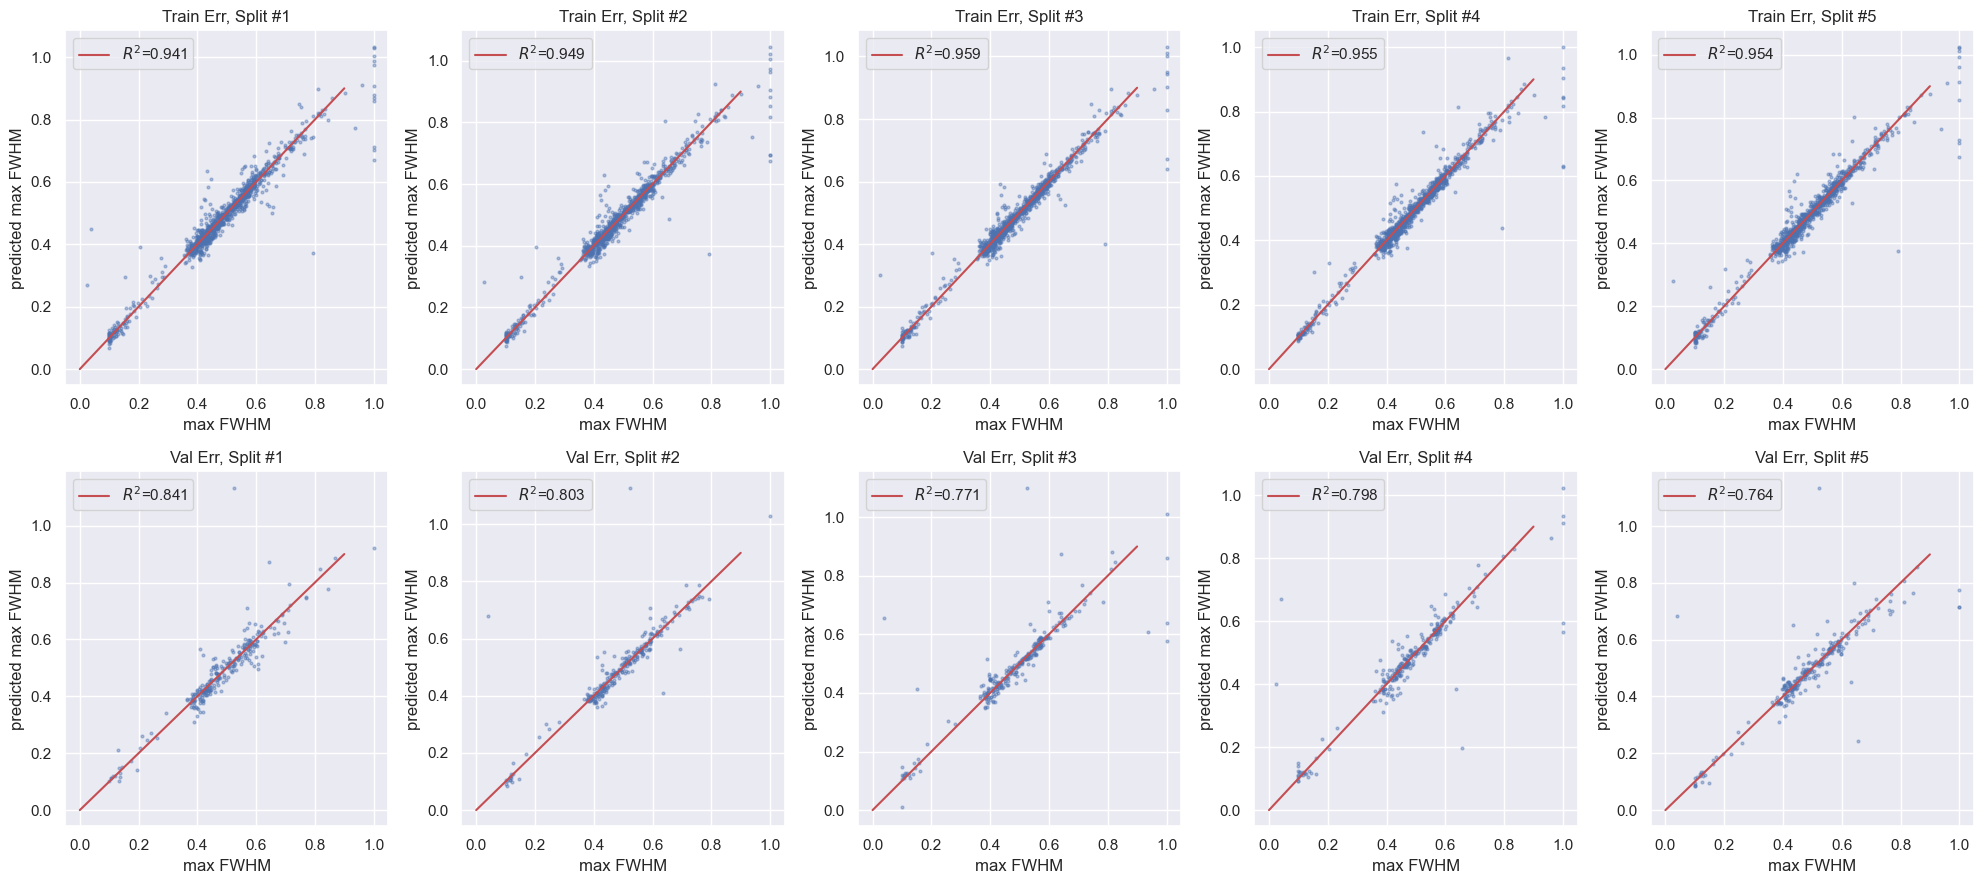

In [341]:
random_cv(dff, n_degree=3, n_split = 5)

### 3. Building models based on previous codes & predict ternary diagrams

First, make a dataframe which contains all the combinations of the four elements, at increment of 0.5 at%

In [342]:
# make an empty dataframe with column names the same as df
quat = pd.DataFrame(columns = df.columns).drop(columns=['MaxFWHM'])

# make a list of all possible compositions, with increment of 0.5
for Co in np.arange(0, 1, 0.05):
    for Ti in np.arange(0, 1-Co, 0.05):
        for Cr in np.arange(0, 1-Co-Ti, 0.05):
            row = pd.DataFrame({'Co': Co, 'Ti': Ti, 'Cr': Cr, 'Zr': 1-Co-Ti-Cr}, index=[0])
            quat = pd.concat([quat, row], ignore_index = True)

In [331]:
quat_f = quat.copy()
quat_f.insert(0, 'formula', 
           'Co' + quat_f['Co'].astype(str) + 'Ti' + quat_f['Ti'].astype(str) + 
           'Cr' + quat_f['Cr'].astype(str) + 'Zr' + quat_f['Zr'].astype(str))

# use the StrToComposition to convert the composition column to a composition object
quat_f = StrToComposition().featurize_dataframe(quat_f, 'formula')
# then use the composition object to calculate the other features
quat_f = AtomicPackingEfficiency().featurize_dataframe(quat_f, col_id='composition')
quat_f = Miedema().featurize_dataframe(quat_f, col_id='composition')
quat_f = YangSolidSolution().featurize_dataframe(quat_f, col_id='composition')

# write featurized quat_f temporarily to a local excel
quat_f.to_excel('quat_f.xlsx')

StrToComposition:   0%|          | 0/1549 [00:00<?, ?it/s]

KeyboardInterrupt: 

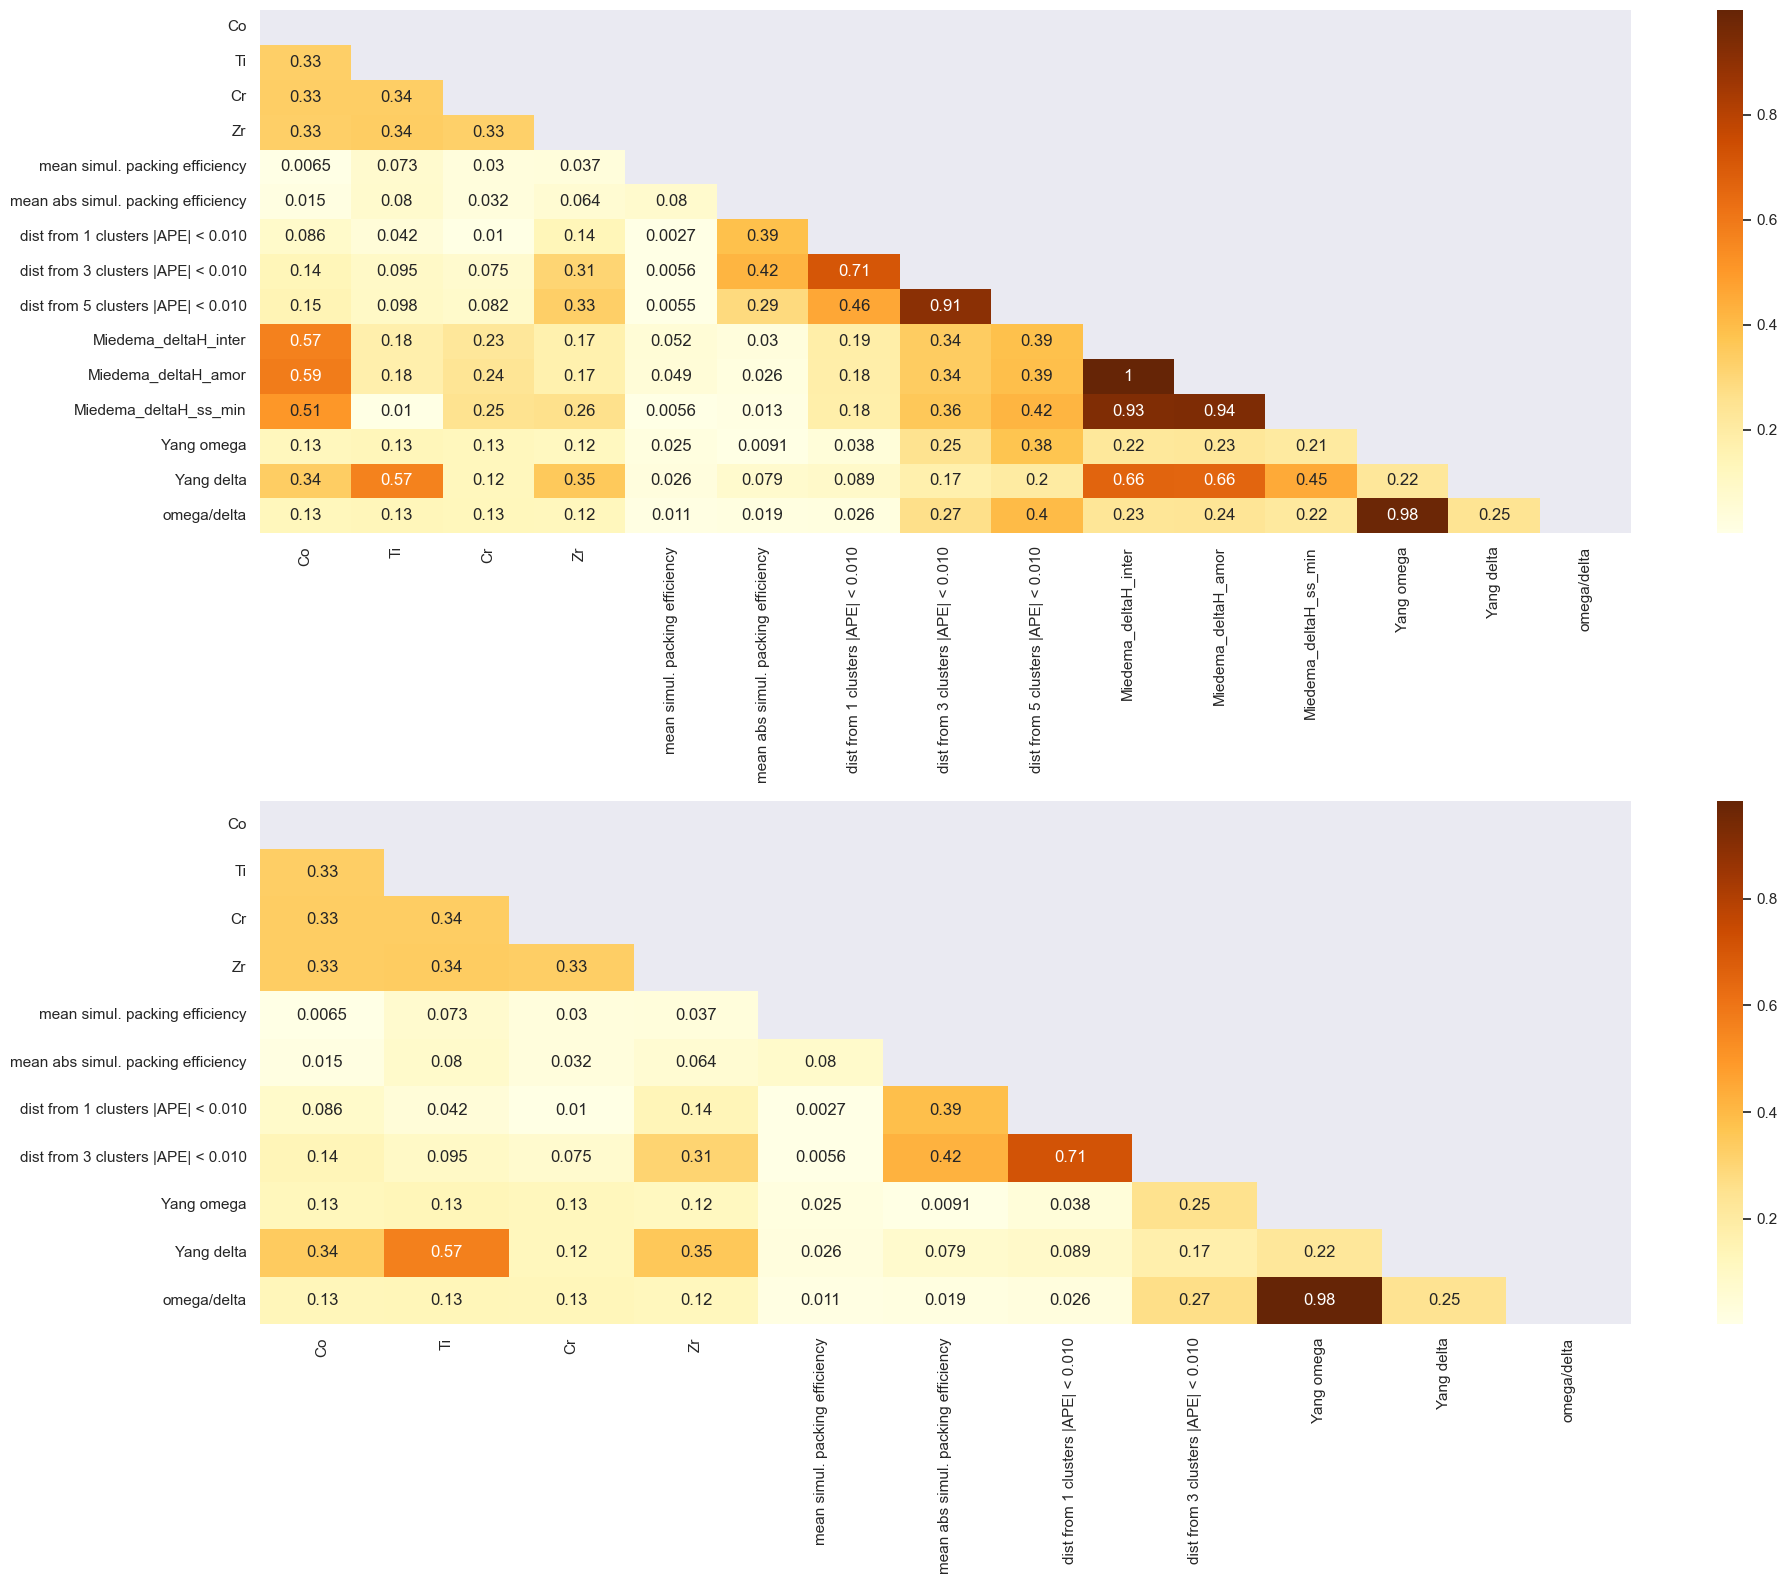

In [343]:
# read back the featurized dataframe
quat_f = pd.read_excel('quat_f.xlsx', index_col=0)

quat_f = quat_f.drop(columns=['formula', 'composition'])
### make an additional feature as used in Yang's paper
# make a new column called 'omega/delta', and fill it with the ratio of omega and delta
quat_f['omega/delta'] = quat_f['Yang omega'] / quat_f['Yang delta']
# drop the rows with NaN
quat_f = quat_f.dropna(axis = 0)

# take a look at what features remains, if we set the threshold to 0.85 (default value)
supervised_drop(quat_f, corr_threshold=0.85, must = ['Miedema_deltaH_inter'], 
                                      exception = ['Yang omega', 'Yang delta', 'omega/delta'], update_df=False)

# Result is good. BUT, to ensure that the same features are present in training and test set,
# drop the features we dropped in dff
quat_f = quat_f.drop(columns=dff_to_drop)



##### 3.1 train & predict using the full model on an composition basis. Here we use the function previously defined called **poly_predict()** which incorporates both preprocessing, fit and predict.

- We used **n_degree = 2** for the polynomial regression below because: n_degree = 1 is underfitting, while n_degree = 3 produces a lot of negative FWHM values

In [344]:
'''Define arrays for train and predict'''

# both models uses the same y to train
y = dff.iloc[:, -1].values

# X_train for element atm% model are only elements (the first 4 columns)
Xe = dff.iloc[:, :4].values
Xcomp_pred_dfict = quat_f.iloc[:, :4].values
y_hat_e = poly_predict(Xe, y, Xcomp_pred_dfict, n_degree = 3, y_train_hat = False) # element model


# Here, X_train for Matminer featurized model has access to all features
# Same process for the training model on Matminer features.
Xf = dff.iloc[:, :-1].values # uses composition AND Matminer features
Xf_pred = quat_f.values

# Xf = dff.iloc[:, 4:-1].values # OR use only Matminer features
# Xf_pred = quat_f.iloc[:, 4:].values

# Here n_degress was determined heuristically
# Matminer featurized model, predicting the entire quaternary system
y_hat_f = poly_predict(Xf, y, Xf_pred, n_degree = 1, y_train_hat = False) 

* we set a drop criteria which drops the compositions where the predicted **MaxFWHM** is unrealistic (greater than 2 or smaller than zero, as is the max and min in the training set)

In [347]:
# Prepare dataframes for Yang Plot. Each plot has 2 Yang's features, and the predicted maxFWHM
# let comp_pred_df be a dataframe the same as quat_f but appended with the predicted MaxFWHM in the last column
comp_pred_df = quat_f.copy()
comp_pred_df['MaxFWHM'] = y_hat_e

# similarly, build a dataframe called feat_pred_df, but with MaxFWHM predicted from Matminer features
feat_pred_df = quat_f.copy()
feat_pred_df['MaxFWHM'] = y_hat_f

'''some post-processing: model should only give a MaxFWHM between 0 and 1 
(and maybe 2 for very broad peaks), so we drop the rows that are outside this range'''
# if the predicted MaxFWHM is < 0 or > 2 , drop the row
comp_pred_df = comp_pred_df[comp_pred_df['MaxFWHM'] > 0]
comp_pred_df = comp_pred_df[comp_pred_df['MaxFWHM'] < 1]

feat_pred_df = feat_pred_df[feat_pred_df['MaxFWHM'] > 0]
feat_pred_df = feat_pred_df[feat_pred_df['MaxFWHM'] < 1]

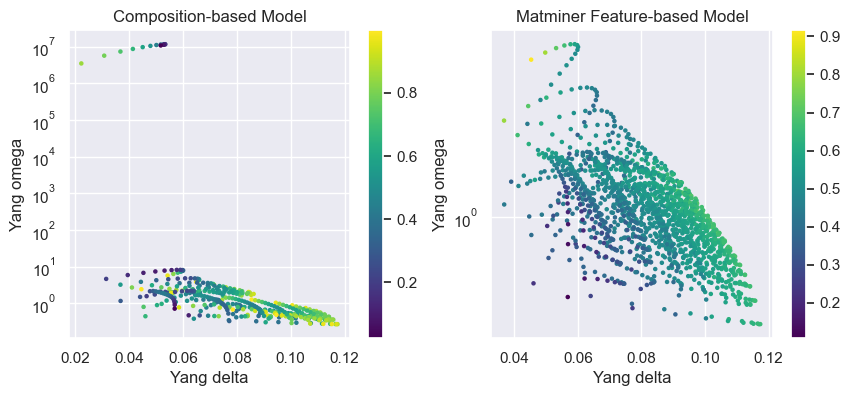

In [349]:
# make a function to plot the Yang plot
def plot_yang(df, plot_title, color_label = None, colorbar = True, cmap = 'viridis'):
    '''This function takes a dataframe with at least the following columns:
    Yang omega, Yang delta, and MaxFWHM. 
    
    It plots the Yang delta vs Yang omega, and color the scatter by MaxFWHM
    '''
    
    # We can choose to color the scatter by either:
    # if color_label is anything other than None, color by color_label
    # else, color by MaxFWHM

    if color_label is not None:
        color = color_label # OR by color label determined from clustering
    else:
        color = df['MaxFWHM'] # by default (MaxFWHM) 
    
    element = plt.scatter(df['Yang delta'], df['Yang omega'], 
                          s = 5, c=color, alpha = 1, cmap=cmap)
    # set the y axis to log scale
    plt.yscale('log')
    # set the title, x and y labels
    plt.title(plot_title)
    plt.xlabel('Yang delta')
    plt.ylabel('Yang omega')
    # ax.colorbar(mappable = None, label='Predicted MaxFWHM', ax=ax)

    if colorbar:
        plt.colorbar(element)

# now plot the two subplots
plt.figure(2, figsize=(10,4))
# make the first subplot
plt.subplot(1, 2, 1)
plot_yang(comp_pred_df, 'Composition-based Model')
plt.subplot(1, 2, 2)
plot_yang(feat_pred_df, 'Matminer Feature-based Model')

Left plot: There is a small cluster (visible in the plot on the left) with extremely high **Yang Omega**. After investigating it was found to be the data points where two of the element columns are zero. This proves that the models trained on ternary systems does not perform well on binary ones.

Right plot: Clearly, the data points with a higher MaxFWHM in yellow are located next to each other. This feature-based model can identify the feature's correlation to FWHM. 

**Therefore, we move on with this model**

Now, we will conduct some simple PCA analysis for clustering, so we can find the appropriate cut-off FWHM

In [350]:
from sklearn.decomposition import PCA
'''below function modified from Assi 4. '''

def pca_plot(X, title, n_comp, y_log = False, color_label = None, return_scree = False):
    '''This function takes and array X, plots the first two principal components, 
    and plots the explained variance ratio as a scree plot.

    It returns the dataset that is cut down to 'n_comp' principal components.'''

    # standardize the data
    X = StandardScaler().fit_transform(X)
    
    pca = PCA(n_components=n_comp)
    pca.fit(X)
    pca_dots = pca.transform(X)

    # this part of PCA is only for plotting Scree Plot
    pca_scree = PCA(n_components=X.shape[1])
    pca_scree.fit(X)
    pca_dots = pca.transform(X)

    # make two subplots, one for pca_dots and one for the explained variance ratio
    if return_scree:
        plt.figure(2, figsize=(10,4))
        plt.subplot(1,2,2) 
        ### now let's see what its explained variance looks like
        plt.plot(pca_scree.explained_variance_ratio_, 'o-')
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Scree Plot')
        plt.subplot(1,2,1)

    if color_label is not None:
        color = color_label # OR by color label determined from clustering
    else:
        color = 'k'

    # map the datapoint in PCA space
    plt.scatter(pca_dots[:,0], pca_dots[:,1], s = 6, c=color, marker='o', alpha=0.3)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    
    if y_log:
        plt.yscale('log')
    
    return pca_dots

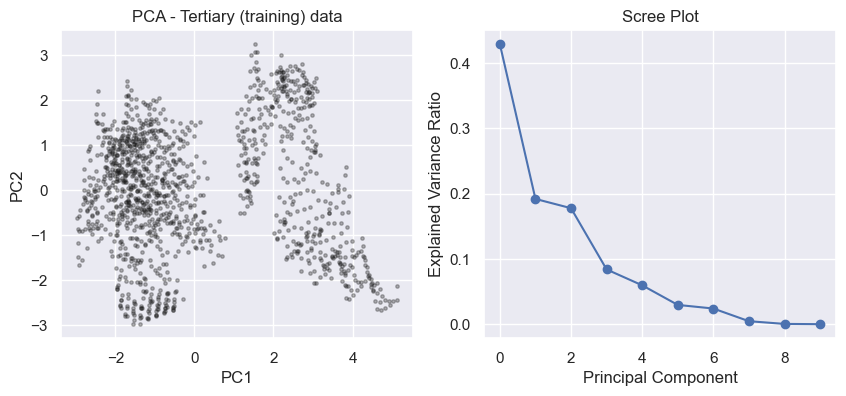

In [355]:
# First, standardize all the data to do cluster on
std = StandardScaler()

### dff is the featurized ternary dataset
# NOTE: we CAN consider the predicted MaxFWHM as a feature, or .iloc[:, :-1] to exclude it
feat_arr_tert = dff.iloc[:, :-1].values 

'''NOTE: n_comp = 6 produces good cluster separation result in the quadrant plot.
This will be discussed in detailed in the quadrant plot section'''

pca_dots_tert = pca_plot(feat_arr_tert, 'PCA - Tertiary (training) data', color_label= 'k',
                        n_comp = 4, return_scree=True)

'NOTE: 3 PCs should be enough. There are multiple factors considered, explained in detail in a markdown below'

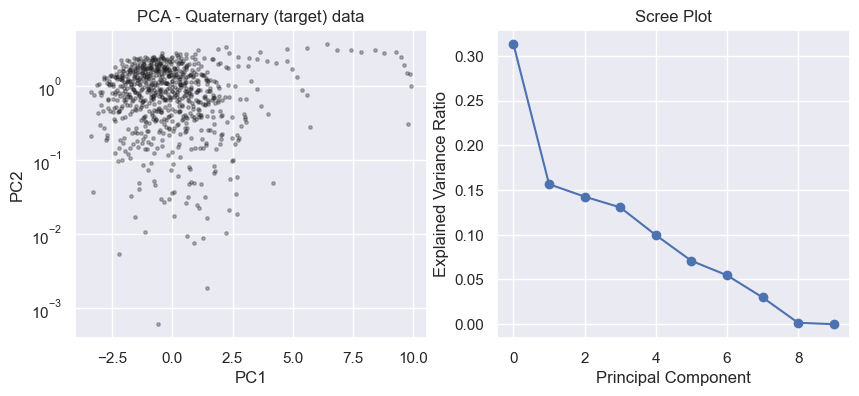

In [361]:
# then, take a look at the PCA of the complete quaternary system
# again, CAN consider the predicted MaxFWHM as a feature, OR not
feat_arr_quat = feat_pred_df.iloc[:, :-1].values

pca_dots_quat = pca_plot(feat_arr_quat, 'PCA - Quaternary (target) data', color_label = 'k',
                        n_comp = 3, y_log = True, return_scree=True)

'''NOTE: 3 PCs should be enough. There are multiple factors considered, explained in detail in a markdown below'''

/Users/baishipu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


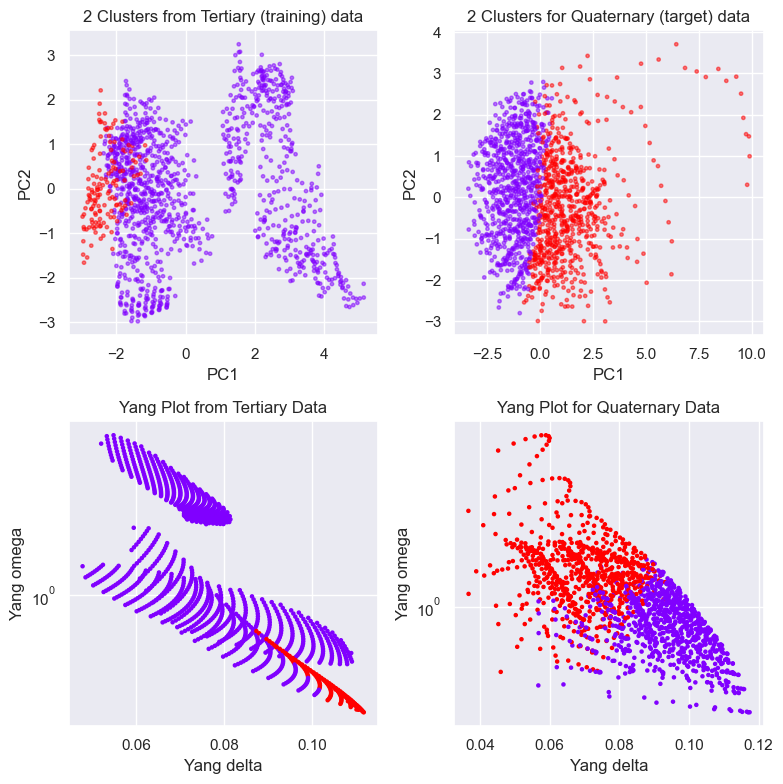

In [362]:
from sklearn.cluster import SpectralClustering
k = 2
SC_tert = SpectralClustering(n_clusters=k, random_state = 2, affinity='nearest_neighbors', n_neighbors=10)

# fit the model to the ternary training data
tert_cluster = SC_tert.fit(pca_dots_tert)
tert_color = tert_cluster.labels_

SC_quat = SpectralClustering(n_clusters=k, random_state = 1, affinity='nearest_neighbors', n_neighbors=10)
# fit the model to the quaternary composition data
quat_cluster = SC_quat.fit(pca_dots_quat)
quat_color = quat_cluster.labels_

color_scheme = 'rainbow'

'''Now plot the two clusters'''
# lets see what the clustering looks like in PCA space
plt.figure(4, figsize=(8, 8))
plt.subplot(2,2,1)
plt.scatter(pca_dots_tert[:,0], pca_dots_tert[:,1], s = 6, c=tert_color, alpha = 0.5, cmap = color_scheme)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(str(k)+' Clusters from Tertiary (training) data')

plt.subplot(2,2,2)
plt.scatter(pca_dots_quat[:,0], pca_dots_quat[:,1], s = 6, c=quat_color, alpha = 0.5, cmap = color_scheme)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(str(k)+' Clusters for Quaternary (target) data')

# specify plot size
plt.subplot(2,2,3)
plot_yang(dff, 'Yang Plot from Tertiary Data', color_label = tert_color, cmap = color_scheme,
          colorbar=False)
# fit the model to the quaternary target data

plt.subplot(2,2,4)
plot_yang(feat_pred_df, 'Yang Plot for Quaternary Data', color_label = quat_color, cmap = color_scheme,
          colorbar = False)
plt.tight_layout()

Looking at the plot above, though top-left plot looks promising for clustering, the hook-shaped cluster on the right actually corresponds to the measurements from Cr-Ti-Zr system.

we (still) need a better approach to determine the cutoff FWHM. For that, we can try quadrant plot: scatter-plot the primary PC against the FWHM

Text(0, 0.5, 'PC1')

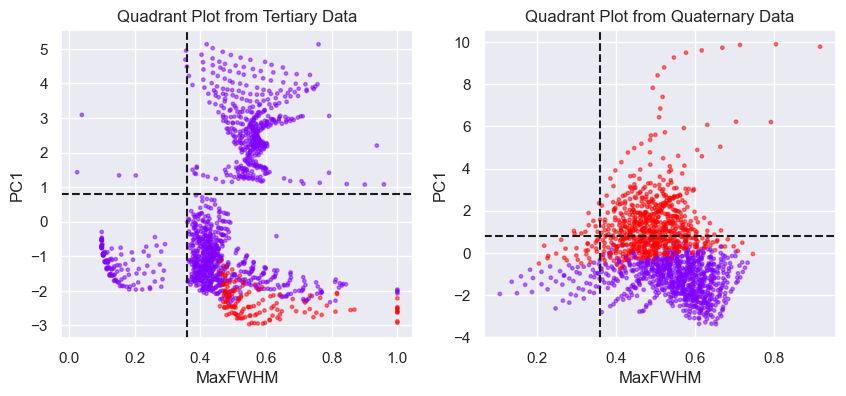

In [443]:
# plot q quadrant plot for the ternary system

# In this new variable, the first column is the major PC (which supposedly gived the best separation)
# the second column is the FWHM (which we are trying to find the threshold for)

# make a new dataframe, with the 1st column being the first column of pca_dots_tert,
# and 2nd column being the MaxFWHM (whether measured or predicted)
PC_v_FWHM_tert = np.column_stack((dff['MaxFWHM'].values, pca_dots_tert[:,0]))
PC_v_FWHM_quat = np.column_stack((feat_pred_df['MaxFWHM'].values, pca_dots_quat[:,0]))

plt.figure(2, figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(PC_v_FWHM_tert[:,0], PC_v_FWHM_tert[:,1], s = 6, c=tert_color, 
            marker='o', alpha=0.5, cmap = color_scheme)
# plot a dashed line at y = 0.5, and another at x = 0.35
plt.axhline(y=0.8, color='k', linestyle='--')
plt.axvline(x=0.36, color='k', linestyle='--')
plt.xlabel('MaxFWHM')
plt.ylabel('PC1')
plt.title('Quadrant Plot from Tertiary Data')

plt.subplot(1,2,2)
plt.scatter(PC_v_FWHM_quat[:,0], PC_v_FWHM_quat[:,1], s = 6, c=quat_color, 
            marker='o', alpha=0.5, cmap = color_scheme)
plt.axhline(y=0.8, color='k', linestyle='--')
plt.axvline(x=0.36, color='k', linestyle='--')
plt.xlabel('MaxFWHM')
plt.title('Quadrant Plot from Quaternary Data')
plt.ylabel('PC1')

This markdown concludes all plots generated during this big step (yes this section is very long). 

Multiple **n_components** and **n_cluster** values were tested. Their values are finalized  after analyzing the following: 

1. scree plot. 

2. cluster distribution when plotted in PC1 vs. PC2 

3. Yang Plot. As shown above on the left, we can see there are three chunks of measurement data likely coming from the excel data of three different ternary systems, and we are expecting a bit of glass phase on one (or more) chunk. So we need to re-cluster if the clustering is clearly just separating the three alloy systems.

4. Quadrant plot. This part is prone to bias as I have tuned the number of PCs and clusters in the previous steps to produce the best quadrant plot. As we are trying to determine the cut-off FWHM, it is best if the clusters are straddled across the MaxFWHM threshold. _From the graph above_, this is unfortunately not quite the case: most data points are on the side where **MaxFWHM > 0.37**. 

_So assuming all above steps are correct_, it is possible that the data provided mostly belongs to the same category: metallic glass. 

Nonetheless, we will move on with **MaxFWHM > 0.37** as our cutoff criteria for metallic glass. Let's plot that on the ternary training data.

In [492]:
# import the function from PRA
import ternary
import numpy.matlib as nm
import matplotlib

def plot_ternary(data, components, z, marker, label, title='', i = 1):
    
    plt.rcParams['figure.figsize'] = [5, 4]

    fig, ax = plt.subplots()
    
    scale = 100
    
    grid = plt.GridSpec(10, 10, wspace=2, hspace=1)
    ax = plt.subplot(grid[:,:9])
    
    figure, tax = ternary.figure(scale=scale, ax=ax)
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="blue", multiple=10)

    # Set Axis labels and Title
    fontsize = 12
    offset = 0.14
    tax.right_corner_label(components[0], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.top_corner_label(components[2], fontsize=fontsize, offset=0.23, fontweight='bold')
    tax.left_corner_label(components[1], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.left_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.right_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025, clockwise= True)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    
    
    # Create color map and plot color bar
    cmap = plt.cm.nipy_spectral
    norm = plt.Normalize(0, z.max())
    
    tax.scatter(data, marker=marker, c=cmap(norm(z)), alpha=1, s=10, vmin=z.min(), vmax=z.max())
    
    ax = plt.subplot(grid[1:-1,9:])
    # cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical', label=label)
    # cb1.set_label(label=label, size=18)


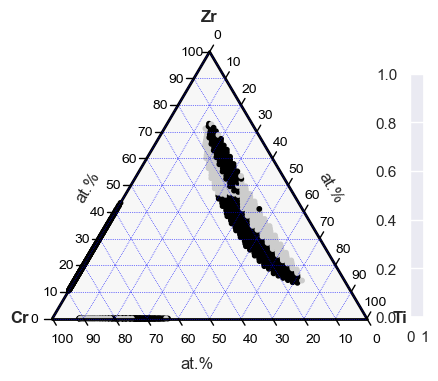

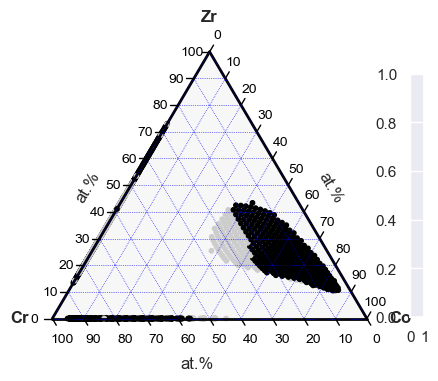

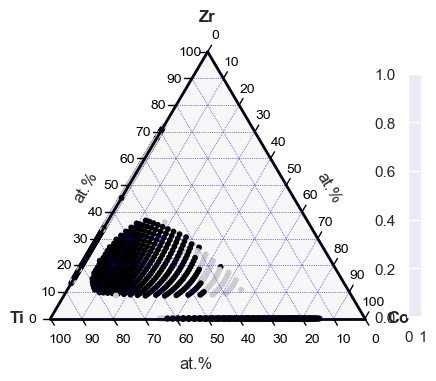

In [493]:
# some preprocessing to visualization:
# make a new  dataframe, which is a copy of feat_pred_df, the fully featurized quaternary system
tert_plot = dff.copy()

# add a new column called 'isGlass': if the MaxFWHM is greater than 0.57, then it is a 1, otherwise it is a 0
tert_plot['isGlass'] = np.where(tert_plot['MaxFWHM'] > 0.57, 1, 0)
tert_plot['isMetallic'] = tert_color

# multiply columns with names 'Co', 'Ti', 'Cr', 'Zr' by 100
tert_plot['Co'] = tert_plot['Co']*100
tert_plot['Ti'] = tert_plot['Ti']*100
tert_plot['Cr'] = tert_plot['Cr']*100
tert_plot['Zr'] = tert_plot['Zr']*100

e_list = ['Co', 'Ti', 'Cr']
# make a plot with three subplots

for ele in e_list:
    # list called element is the e_list minus the current element
    elements = [x for x in e_list if x != ele]
    elements.append('Zr')

    cmp = tert_plot.loc[:,elements].to_numpy()
    points=nm.vstack((cmp[:,0].T, cmp[:,1].T)).T

    # plot the first subplot
    
    plot_ternary(points, elements, z = tert_plot['isGlass'], marker = 'o',
                  label = 'FWHM', title='', i = e_list.index(ele)+1)

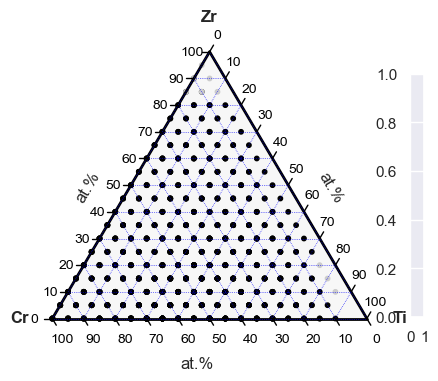

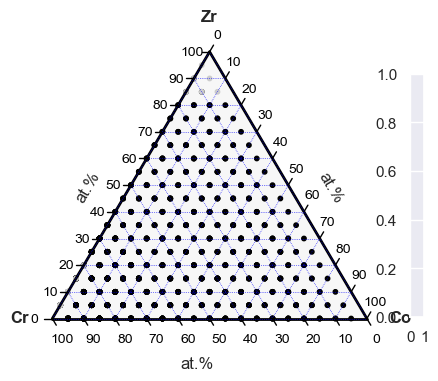

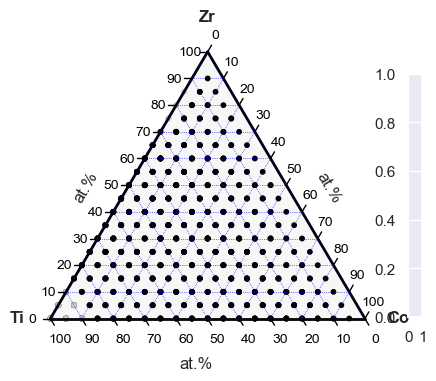

In [494]:
# some preprocessing to visualization:
# make a new  dataframe, which is a copy of feat_pred_df, the fully featurized quaternary system
quat_plot = feat_pred_df.copy()

# add a new column called 'isGlass': if the MaxFWHM is greater than 0.37, then it is a 1, otherwise it is a 0
quat_plot['isGlass'] = np.where(quat_plot['MaxFWHM'] > 0.57, 1, 0)
quat_plot['isMetallic'] = quat_color

# multiply columns with names 'Co', 'Ti', 'Cr', 'Zr' by 100
quat_plot['Co'] = quat_plot['Co']*100
quat_plot['Ti'] = quat_plot['Ti']*100
quat_plot['Cr'] = quat_plot['Cr']*100
quat_plot['Zr'] = quat_plot['Zr']*100

e_list = ['Co', 'Ti', 'Cr']

for ele in e_list:
    # list called element is the e_list minus the current element
    elements = [x for x in e_list if x != ele]
    elements.append('Zr')

    cmp = quat_plot.loc[:,elements].to_numpy()
    points=nm.vstack((cmp[:,0].T, cmp[:,1].T)).T

    plot_ternary(points, elements, z = quat_plot['isGlass'], marker = 'o',
                  label = 'FWHM', title='')
    plt.show()

From the plots above, the model is not predicting the three ternary systems very well. There could be several reasons: 

1. the feature used was not descriptive enough.

2. there are a few correlated features that was kept (by my will), such as between **Yang omega** and **omega/delta**. This could affect their relative weight during PCA, which further affects the results of clustering